In [11]:
import pandas as pd
import json
import time
import numpy as np
from IPython.display import display
import ipywidgets as widgets
import holidays

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

import seaborn as sns
import matplotlib.pyplot as plt

## Step 1: Import Data

In [57]:
# Load data
data = pd.read_csv('POP_49824rows_DEC2015_sp_yt_usdemogr.csv') 
data.head(3)

/Users/Sherry/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (48) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,Event Date,Number of Shows,Headliner,Support,Venue,City,State,Country,Market,...,20 to 24 years population,25 to 34 years population,35 to 44 years population,45 to 54 years population,55 to 59 years population,60 to 64 years population,65 to 74 years population,75 to 84 years population,85 years and over population,Median age
0,0,9/18/2024,1,Creed,"3 Doors Down, Finger Eleven",Coastal Credit Union Music Park at Walnut Creek,Raleigh,North Carolina,United States,Raleigh-Durham (Fayetteville),...,39470.0,86563.0,67091.0,60170.0,26831.0,22056.0,32176.0,14987.0,6107.0,34.6
1,1,9/14/2024,1,Creed,"3 Doors Down, Finger Eleven",The Cynthia Woods Mitchell Pavilion,The Woodlands,Texas,United States,Houston,...,5185.0,11317.0,15998.0,19779.0,8835.0,5980.0,10148.0,4306.0,1822.0,40.7
2,2,9/13/2024,1,Bruce Springsteen & The E Street Band,NaN,Oriole Park at Camden Yards,Baltimore,Maryland,United States,Baltimore,...,38348.0,108037.0,77668.0,64094.0,35439.0,38588.0,52849.0,23684.0,9862.0,36.0


In [58]:
for column in data.columns:
    print(f"Column: {column}, Data Type: {data[column].dtype}")

Column: Unnamed: 0, Data Type: int64
Column: Event Date, Data Type: object
Column: Number of Shows, Data Type: int64
Column: Headliner, Data Type: object
Column: Support, Data Type: object
Column: Venue, Data Type: object
Column: City, Data Type: object
Column: State, Data Type: object
Column: Country, Data Type: object
Column: Market, Data Type: object
Column: Company Type, Data Type: object
Column: Currency, Data Type: object
Column: Promoter, Data Type: object
Column: Genre, Data Type: object
Column: Avg. Tickets Sold, Data Type: object
Column: Avg. Gross USD, Data Type: object
Column: Avg. Event Capacity, Data Type: object
Column: Avg. Capacity Sold, Data Type: object
Column: Ticket Price Min USD, Data Type: object
Column: Ticket Price Max USD, Data Type: object
Column: Ticket Price Avg. USD, Data Type: object
Column: 字段21, Data Type: float64
Column: sp artist_name, Data Type: object
Column: sp artist_genre, Data Type: object
Column: sp followers, Data Type: float64
Column: sp popu

##  Step 2: Data processing

In [59]:
# drop column 字段21
data = data.drop(columns=["字段21"])

# Check if 'Event Date' column contains valid dates
data['Event Date'] = pd.to_datetime(data['Event Date'], errors='coerce')

# Drop rows where 'Event Date' is null (indicating invalid date)
data = data.dropna(subset=['Event Date'])

# Reset index after dropping rows
data = data.reset_index(drop=True)

# Remove commas,dollar sign and convert to float
columns_with_commas = ['Avg. Event Capacity', 'Ticket Price Max USD','Ticket Price Min USD','Ticket Price Avg. USD','Avg. Gross USD','Avg. Tickets Sold']
for column in columns_with_commas:
    data[column] = data[column].str.replace(r'[$,]', '', regex=True).astype(float)

# Convert all object-type columns to string
data = data.astype({col: 'string' for col in data.select_dtypes(include='object').columns})

    

In [60]:
# Extra Features: Location
# create a Location column using 'City', 'State','Country'
# not using state here since lots of country do not have state
data['Location'] = data['City'] + '_' + data['Country']

# Extra Features: seasonality
# extract month from Event Date to represent seasonality
data['Event Date'] = pd.to_datetime(data['Event Date'], format='%m/%d/%Y')
data['Month'] = data['Event Date'].dt.month


# Extra Features: day of the week
# Convert the date column to datetime format if it's not already in datetime format
data['Event Date'] = pd.to_datetime(data['Event Date'])
# Extract the day of the week (0 = Monday, 1 = Tuesday, ..., 6 = Sunday)
data['day_of_week'] = data['Event Date'].dt.dayofweek

# Extra feature: Holiday or Not
def is_holiday(date):
    us_holidays = holidays.US()
    return date in us_holidays
data['is_holiday'] = data['Event Date'].apply(is_holiday)

In [61]:
# Reset index after dropping rows
data = data.reset_index(drop=True)

In [62]:
# check the avaiablity of each features
# Calculate the percentage of non-null values for each column
percentages = {}
data_types = {}
for column in data.columns:
    percentage = (data[column].count() / len(data)) * 100
    percentages[column] = percentage
    # Get the data type of each column
    data_types[column] = data[column].dtype

# Convert the dictionaries to a DataFrame
result_df = pd.DataFrame({
    'Percentage': percentages,
    'Data Type': data_types
})

# Set the index name
result_df.index.name = 'Column'

print(result_df)

                              Percentage       Data Type
Column                                                  
Unnamed: 0                    100.000000           int64
Event Date                    100.000000  datetime64[ns]
Number of Shows               100.000000           int64
Headliner                     100.000000          string
Support                        48.646901          string
Venue                          99.987685          string
City                          100.000000          string
State                          99.993843          string
Country                       100.000000          string
Market                         98.192790          string
Company Type                   99.978449          string
Currency                      100.000000          string
Promoter                       99.990764          string
Genre                         100.000000          string
Avg. Tickets Sold             100.000000         float64
Avg. Gross USD                1

In [68]:
# Drop rows where 'sp followers' is null (indicating no spotify page is found)
data = data.dropna(subset=['sp followers'])
# Drop rows where 'yt Subscriber Count' is null (indicating no youtube channel is found)
data = data.dropna(subset=['yt Subscriber Count'])
# Drop rows where 'yt Subscriber Count' is null (indicating no youtube channel is found)
# Remove any hyphens
data['Median age'] = data['Median age'].str.replace(r'[-]', '', regex=True)
# Replace empty strings with NaN
data['Median age'].replace('', np.nan, inplace=True)
# Drop rows where 'Median age' is NaN
data = data.dropna(subset=['Median age'])
# Convert 'Median age' to float
data['Median age'] = data['Median age'].astype(float)

In [71]:
# check distribution
distribution_summary = data['Avg. Gross USD'].describe()
print("Distribution Summary:",distribution_summary)
distribution_summary = data['Ticket Price Avg. USD'].describe()
print("Distribution Summary:",distribution_summary)

Distribution Summary: count    3.204700e+04
mean     2.016874e+05
std      6.182607e+05
min      1.125000e+01
25%      5.613500e+03
50%      2.266500e+04
75%      1.143381e+05
max      1.349418e+07
Name: Avg. Gross USD, dtype: float64
Distribution Summary: count    32046.000000
mean        42.456990
std         37.160309
min          0.090000
25%         20.000000
50%         30.835000
75%         53.490000
max        524.950000
Name: Ticket Price Avg. USD, dtype: float64


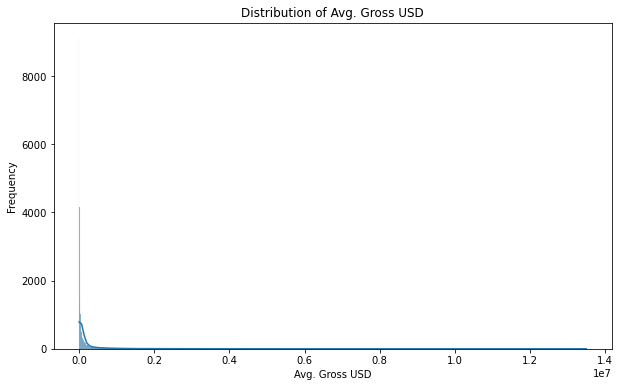

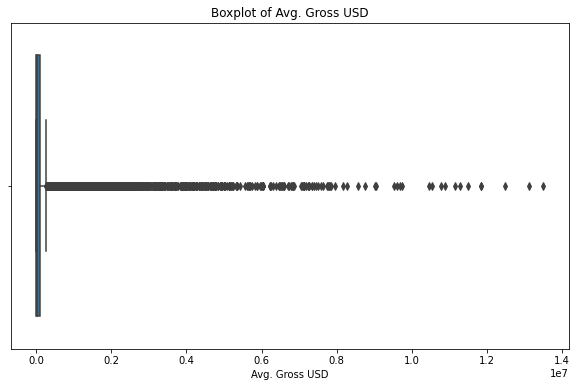

In [72]:
# Plot the distribution using a histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='Avg. Gross USD', kde=True)
plt.title('Distribution of Avg. Gross USD')
plt.xlabel('Avg. Gross USD')
plt.ylabel('Frequency')
plt.show()

# Identify outliers using a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='Avg. Gross USD')
plt.title('Boxplot of Avg. Gross USD')
plt.xlabel('Avg. Gross USD')
plt.show()

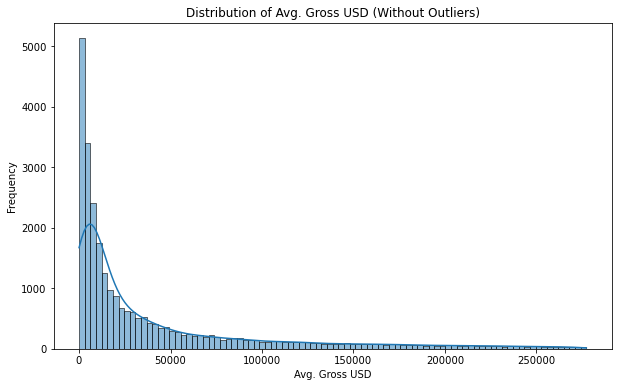

In [73]:
# Define the lower and upper bounds
Q1 = data['Avg. Gross USD'].quantile(0.25)
Q3 = data['Avg. Gross USD'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to remove outliers
data = data[(data['Avg. Gross USD'] >= lower_bound) & (data['Avg. Gross USD'] <= upper_bound)]

# Plot the distribution without outliers
plt.figure(figsize=(10, 6))
# sns.histplot(data=data_no_outliers, x='Avg. Gross USD', kde=True)
sns.histplot(data=data, x='Avg. Gross USD', kde=True)
plt.title('Distribution of Avg. Gross USD (Without Outliers)')
plt.xlabel('Avg. Gross USD')
plt.ylabel('Frequency')
plt.show()

In [74]:
# Convert categorical 'day_of_week' variable using one-hot encoding
data_encoded = pd.get_dummies(data, columns=['day_of_week'], drop_first=True)

In [75]:
# output the data into a csv file
data_encoded.to_csv('cleaned_data_allpop.csv', index=False)

# Step 3: Model Training

In [76]:
# Load data
data = pd.read_csv('cleaned_data_allpop.csv') 
data.head(3)

,Unnamed: 0,Event Date,Number of Shows,Headliner,Support,Venue,City,State,Country,Market,...,Median age,Location,Month,is_holiday,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,8,2024-09-10,1,Jerome Collins,NaN,City Winery Nashville,Nashville-Davidson metropolitan government (ba...,Tennessee,United States,Nashville,...,34.6,Nashville-Davidson metropolitan government (ba...,9,False,1,0,0,0,0,0
1,9,2024-09-10,1,Meghan Trainor,Paul Russell,FirstBank Amphitheater,Franklin,Tennessee,United States,Nashville,...,37.8,Franklin_United States,9,False,1,0,0,0,0,0
2,11,2024-09-08,1,Paul Weller,NaN,Citizens House of Blues Boston,Boston,Massachusetts,United States,Boston (Manchester),...,32.9,Boston_United States,9,False,0,0,0,0,0,1


In [78]:
# Split data into features (X) and target variable (y)
X = data.drop('Avg. Gross USD', axis=1) 
y = data['Avg. Gross USD']
selected_columns=['Avg. Event Capacity'
                  ,'yt Subscriber Count'
                  ,'sp followers'
                  ,'sp popularity'
                  , 'Ticket Price Min USD'
                 ]
X=X[selected_columns]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=88)

In [82]:
# Initialize the Linear Regression model
model = LinearRegression()

# Define scoring functions for RMSE and R^2
rmse_scorer = make_scorer(mean_squared_error, squared=False)  # RMSE
r2_scorer = make_scorer(r2_score)  # R^2

# Perform cross-validation for RMSE
cv_rmse_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=rmse_scorer)
average_rmse = np.mean(cv_rmse_scores)

# Perform cross-validation for R^2
cv_r2_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=r2_scorer)
average_r2 = np.mean(cv_r2_scores)

print("Cross-Validation RMSE for each fold:", cv_rmse_scores)
print("Average Cross-Validation RMSE:", average_rmse)
print("Cross-Validation R^2 for each fold:", cv_r2_scores)
print("Average Cross-Validation R^2:", average_r2)

# Train the model on the full training data
model.fit(X_train, y_train)

# Evaluate on the test set
y_pred = model.predict(X_test)

# Calculate RMSE and R^2 on the test set
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
test_r2 = r2_score(y_test, y_pred)

print("Test RMSE:", test_rmse)
print("Test R^2:", test_r2)

Cross-Validation RMSE for each fold: [34010.12518979 37746.34620341 35167.4890139  36173.04593272
 50267.07457432]
Average Cross-Validation RMSE: 38672.8161828263
Cross-Validation R^2 for each fold: [0.65385534 0.59969261 0.63501759 0.6330832  0.24867767]
Average Cross-Validation R^2: 0.5540652812966234
Test RMSE: 45443.240942041615
Test R^2: 0.36591416556402034
